In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib import colors

#### Import Data

In [3]:
data_vec_str = ['center_surround', 'spiral', 'two_gaussians', 'xor']
data_vec = [[pd.read_csv(f'{data}_train.csv'), pd.read_csv(f'{data}_valid.csv'), pd.read_csv(f'{data}_test.csv')] for data in data_vec_str]

#### Set additional parameters

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### 1 - PyTorch Implementation with MCE

In [5]:
class Data(Dataset):
  def __init__(self, data, targets):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.labels = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

class FeedForward(nn.Module):
  def __init__(self, size_in, size_out, k, device=device):
    super(FeedForward, self).__init__()
    self.linearStack = nn.Sequential(
        nn.Linear(size_in, k),
        nn.Tanh(),
        nn.Linear(k, size_out),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    x = self.linearStack(x)
    return x
  
def train_model(model, dataloader, criterion, optimizer, device):
  model.train()
  tot_train_loss = 0
  for data, target in dataloader:
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data).squeeze()
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      tot_train_loss += loss.item()
  return tot_train_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion, device):
  model.eval()
  targets = []
  predictions = []
  total_loss = 0
  with torch.no_grad():
      for data, target in dataloader:
          data, target = data.to(device), target.to(device)
          output = model(data).squeeze()
          loss = criterion(output, target)
          total_loss += loss.item()
          predictions.extend(output.cpu().numpy())
          targets.extend(target.cpu().numpy())
  # Calculate binary classification metrics
  predictions = np.array(predictions) > 0.5  # Threshold at 0.5
  accuracy = accuracy_score(targets, predictions)
  avg_loss = total_loss / len(dataloader)
  return predictions, accuracy, avg_loss

def process_data(train_df, valid_df, test_df, batch_size, shuffle):
  # set up data
  train_data_df = train_df.loc[:, train_df.columns != 'label']
  train_target_df = train_df['label']
  valid_data_df = valid_df.loc[:, valid_df.columns != 'label']
  valid_target_df = valid_df['label']
  test_data_df = test_df.loc[:, test_df.columns != 'label']
  test_target_df = test_df['label']

  len_features = len(train_data_df.columns)

  # fit and transform data
  sc = StandardScaler()
  train_data_df = sc.fit_transform(train_data_df)
  test_data_df = sc.transform(test_data_df)
  valid_data_df = sc.transform(valid_data_df)

  # set up and implement data loaders
  train_data = Data(train_data_df, train_target_df)
  valid_data = Data(valid_data_df, valid_target_df)
  test_data = Data(test_data_df, test_target_df)
  train_loader = DataLoader(train_data, batch_size, shuffle)
  valid_loader = DataLoader(valid_data, batch_size, shuffle)
  test_loader = DataLoader(test_data, batch_size, shuffle)

  return train_loader, valid_loader, test_loader, len_features, test_data_df, test_target_df

In [111]:
data_params = {
    'center_surround': {
        'batch_size': 32,
        'shuffle': False,
        'k': 9,
        'lr': 1e-2,
        'epochs': 500
    },
    'spiral': {
        'batch_size': 32,
        'shuffle': False,
        'k': 5,
        'lr': 1e-2,
        'epochs': 300
    },
    'two_gaussians': {
        'batch_size': 32,
        'shuffle': False,
        'k': 2,
        'lr': 1e-2,
        'epochs': 100
    },
    'xor': {
        'batch_size': 32,
        'shuffle': False,
        'k': 2,
        'lr': 1e-2,
        'epochs': 400
    }
} # k = {2, 3, 5, 7, 9}

Training on center_surround data
Training on spiral data
Training on two_gaussians data
Training on xor data


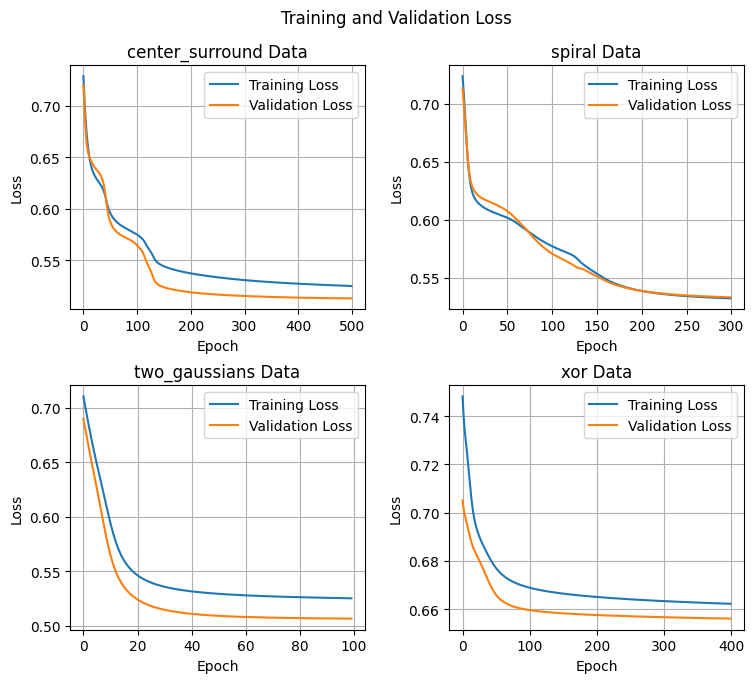

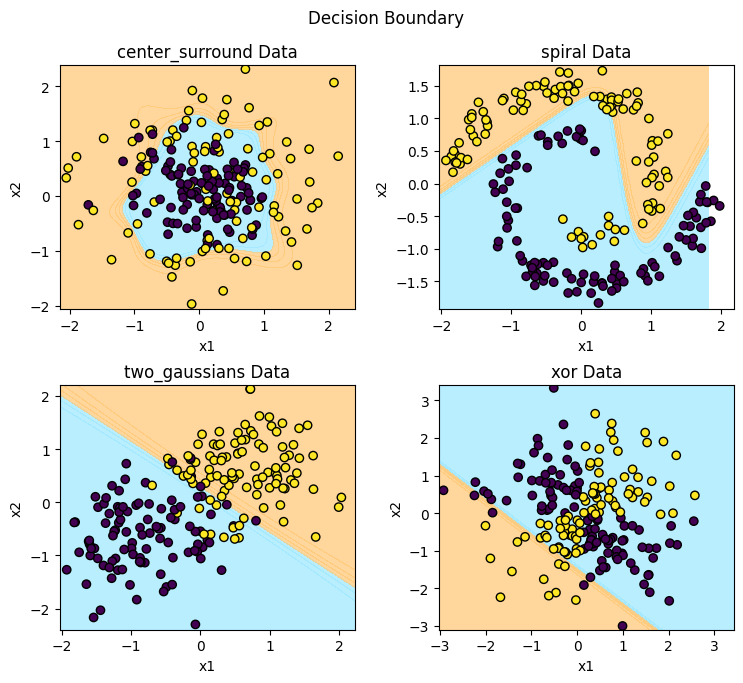

,Data,Accuracy,Loss,Batch Size,Shuffle,k,Learning Rate,Epochs
0,center_surround,0.720,0.618873,32,False,9,0.01,500
1,spiral,0.910,0.535157,32,False,5,0.01,300
2,two_gaussians,0.905,0.551548,32,False,2,0.01,100
3,xor,0.575,0.680843,32,False,2,0.01,400


In [112]:
fig_loss, axes_loss = plt.subplots(2, 2, figsize=(8, 7))
fig_loss.suptitle('Training and Validation Loss')
fig_loss.tight_layout(pad=3.0)
fig_loss.subplots_adjust(top=0.90)

fig_decision, axes_decision = plt.subplots(2, 2, figsize=(8, 7))
fig_decision.suptitle('Decision Boundary')
fig_decision.tight_layout(pad=3.0)
fig_decision.subplots_adjust(top=0.90)

results = pd.DataFrame(columns=['Data', 'Accuracy', 'Loss', 'Batch Size', 'Shuffle', 'k', 'Learning Rate', 'Epochs'])


for idx in range(len(data_vec_str)):
    data_str = data_vec_str[idx]
    batch_size = data_params[data_str]['batch_size']
    shuffle = data_params[data_str]['shuffle']
    k = data_params[data_str]['k']
    lr = data_params[data_str]['lr']
    epochs = data_params[data_str]['epochs']
    print(f"Training on {data_str} data")
    
    # set up data
    train_loader, valid_loader, test_loader, len_features, test_data, test_target = \
        process_data(data_vec[idx][0], data_vec[idx][1], data_vec[idx][2], batch_size, shuffle)
    
    # set up model
    model = FeedForward(len_features, 1, k).to(device)
    loss_fun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train model
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        avg_train_loss = train_model(model, train_loader, loss_fun, optimizer, device)    
        _, accuracy, avg_valid_loss = evaluate_model(model, valid_loader, loss_fun, device)
        training_loss.append(avg_train_loss)
        validation_loss.append(avg_valid_loss)
        # if epoch % 100 == 0:
        #     print(f'Epoch {epoch}: Validation Accuracy: {accuracy:.4f}')

    # Plot training and validation loss
    axes_loss[idx//2, idx%2].plot(training_loss, label='Training Loss')
    axes_loss[idx//2, idx%2].plot(validation_loss, label='Validation Loss')
    axes_loss[idx//2, idx%2].set_xlabel('Epoch')
    axes_loss[idx//2, idx%2].set_ylabel('Loss')
    axes_loss[idx//2, idx%2].legend()
    axes_loss[idx//2, idx%2].grid(True)
    axes_loss[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

    # Evaluate model
    predictions, accuracy, avg_test_loss = evaluate_model(model, test_loader, loss_fun, device)
    results.loc[idx] = [data_vec_str[idx], accuracy, avg_test_loss, batch_size, shuffle, k, lr, epochs]

    # Plot decision boundaries (assumes two features)
    min1, max1 = test_data[:, 0].min()-0.1, test_data[:, 1].max()+0.1
    min2, max2 = test_data[:, 1].min()-0.1, test_data[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.arange(min1, max1, 0.05), np.arange(min2, max2, 0.05))
    grid = np.c_[xx.ravel(), yy.ravel()]
    z = model(torch.tensor(grid, dtype=torch.float32).to(device)).detach().cpu().numpy()
    zz = z.reshape(xx.shape)

    binary_cmap = colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axes_decision[idx//2, idx%2].contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)
    axes_decision[idx//2, idx%2].scatter(test_data[:,0], test_data[:,1], c=test_target, edgecolor='k')
    axes_decision[idx//2, idx%2].set_xlabel('x1')
    axes_decision[idx//2, idx%2].set_ylabel('x2')
    axes_decision[idx//2, idx%2].set_title(f'{data_vec_str[idx]} Data')

plt.show()
display(results)

### 2 - PyTorch Implementation with MSE

### 3 - Manual Gradients and Updates

### 4 - Regularizers